# Computation Graph Data Generation Model

In [1]:
import networkx as nx
from computation_graph_dgm import ComputationGraphDGM, draw_topological_order
import string

## Exploration

In [2]:
var_vocab = list(string.ascii_lowercase) # letters a-z
function_map = {'sum': sum}
mod_val = 16

dgm = ComputationGraphDGM(var_vocab=var_vocab, function_map=function_map, mod_val=mod_val)

In [4]:
example = dgm.sample_example(n_vars=5, func_degree=2, query_var='random', verbose=True)

topological order of variables in DAG: ['g', 's', 'f', 'p', 'r']
g <- 5
s <- 5
f <- sum(s, g)
p <- sum(s, f)
r <- sum(p, s)

prompt: 5 -> g <eq_sep> 5 -> s <eq_sep> sum ( s , g ) -> f <eq_sep> sum ( s , f ) -> p <eq_sep> sum ( p , s ) -> r <eq_sep>

Solving computation graph...
initializing node values:
{'5': 5, 'g': None, 's': None, 'f': None, 'p': None, 'r': None}

now iterating in topological order and solving for the value of each node...

Children(g) = ['5=5']
g <- leafValueAssignment([5]) = 5

Children(s) = ['5=5']
s <- leafValueAssignment([5]) = 5

Children(f) = ['s=5', 'g=5']
f <- sum([5, 5]) = 10

Children(p) = ['s=5', 'f=10']
p <- sum([5, 10]) = 15

Children(r) = ['p=15', 's=5']
r <- sum([15, 5]) = 20

5 -> g <eq_sep> 5 -> s <eq_sep> sum ( s , g ) -> f <eq_sep> sum ( s , f ) -> p <eq_sep> sum ( p , s ) -> r <eq_sep> <query> s <answer> 5


In [4]:
for k, v in example.items():
    print(k)
    print(v)
    print()

prompt
[6, '->', 'b', '<eq_sep>', 10, '->', 'j', '<eq_sep>', 'sum', '(', 'b', ',', 'j', ')', '->', 'q', '<eq_sep>', 'sum', '(', 'j', ',', 'b', ')', '->', 'w', '<eq_sep>', 'sum', '(', 'w', ',', 'j', ')', '->', 'd', '<eq_sep>']

edges
[(6, 'b'), (10, 'j'), ('b', 'q'), ('j', 'q'), ('j', 'w'), ('b', 'w'), ('w', 'd'), ('j', 'd')]

func_annotations
{'b': 'leafValueAssignment', 'j': 'leafValueAssignment', 'q': 'sum', 'w': 'sum', 'd': 'sum'}

var_top_order
['b', 'j', 'q', 'w', 'd']

node_vals
{6: 6, 'b': 6, 10: 10, 'j': 10, 'q': 16, 'w': 16, 'd': 26}

query_var
d

query_prompt
[6, '->', 'b', '<eq_sep>', 10, '->', 'j', '<eq_sep>', 'sum', '(', 'b', ',', 'j', ')', '->', 'q', '<eq_sep>', 'sum', '(', 'j', ',', 'b', ')', '->', 'w', '<eq_sep>', 'sum', '(', 'w', ',', 'j', ')', '->', 'd', '<eq_sep>', '<query>', 'd', '<answer>', '26']

tokenized_query_prompt
[32, 46, 1, 49, 36, 46, 9, 49, 42, 44, 1, 43, 9, 45, 46, 16, 49, 42, 44, 9, 43, 1, 45, 46, 22, 49, 42, 44, 22, 43, 9, 45, 46, 3, 49, 47, 3, 48, 51]

is DAG: True


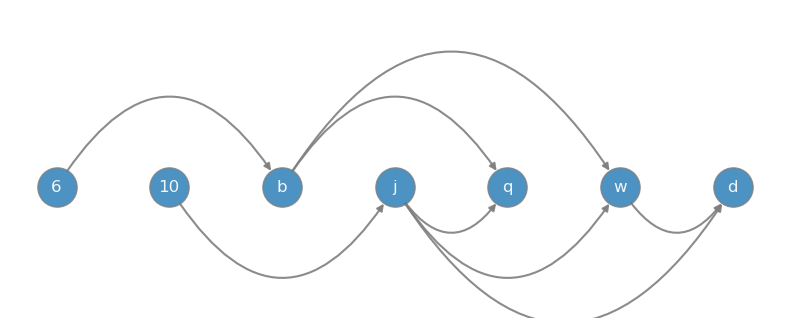

In [5]:
G = nx.from_edgelist(example['edges'], create_using=nx.DiGraph)
nx.set_node_attributes(G, example['func_annotations'], 'func')
print(f'is DAG: {nx.is_directed_acyclic_graph(G)}')

draw_topological_order(example, numeric_vocab=dgm.numeric_vocab, figsize=(10, 4));

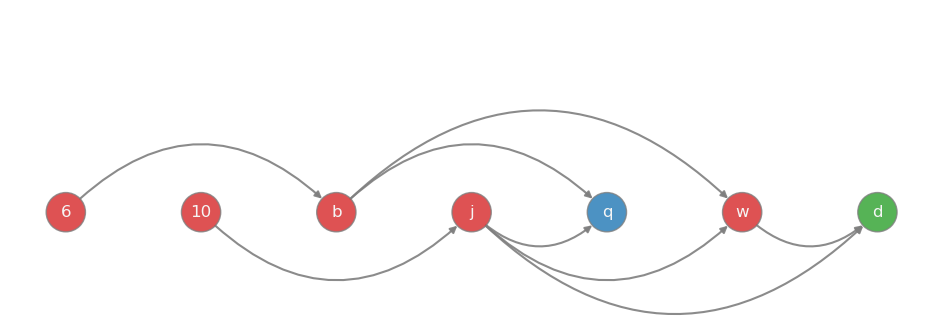

In [6]:
draw_topological_order(example, numeric_vocab=dgm.numeric_vocab, figsize=(12, 4), query_node=example['query_var'], rad=-0.5);

## Generate Data

In [7]:
from tqdm import tqdm, trange

In [8]:
n_var_range = list(range(2, 20))
samples_per_n_var = 1000

data = []
for n_vars in tqdm(n_var_range):
    for _ in trange(samples_per_n_var, leave=False):
        example = dgm.sample_example(n_vars=n_vars, func_degree=2)
        data.append(example['tokenized_query_prompt'])

print(f'Number of examples: {len(data)}')

  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:11<00:00,  1.63it/s]

Number of examples: 18000


/home/awni/miniconda3/envs/abstract_transformer/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


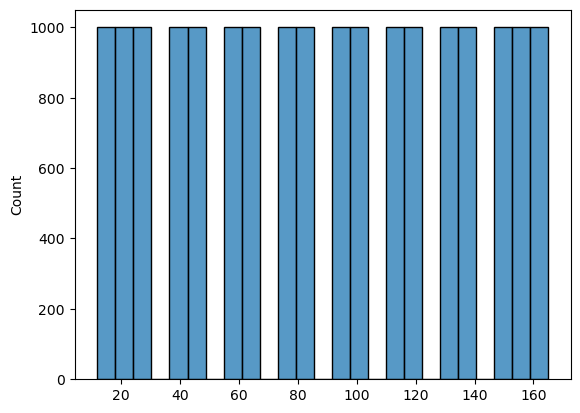

In [9]:
import seaborn as sns

sns.histplot([len(x) for x in data]);